# Practical Linear Algebra for Data Science

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# setup animation
import matplotlib.animation as animation
from matplotlib import rc

rc("animation", html="jshtml")


# to read an image from a url (io) and convert it to grayscale (color)
from skimage import io, color

# convolution
from scipy.signal import convolve2d
from scipy.linalg import hilbert

import scipy


import pandas as pd
import sympy as sym
import seaborn as sns
from sklearn import datasets
from sklearn.decomposition import PCA


import time


# NOTE: these lines define global figure properties used for publication.
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats(
    "svg"
)  # display figures in vector format
plt.rcParams.update({"font.size": 8})  # set global font size

###### ============================
# Chapter 15
## EIG and SVD Applications

###### ============================
### PCA using Eig and SVD

Purpose of PCA is to find a set of basis vectors for a dataset that point in the direction that maximizes covariation across the variables.

#### The Math
We want to find the linear weighted combinations across all varuables that maximisez the variance of the components.
Variance is the measuare of dispresion of a dataset arund its average value.

So we can write the equation we want to maximize as for $w$ for a mean centered data $X$:

$$\lambda=\frac{||Xw||^2}{||w||^2} \implies \lambda=\frac{w^TX^TXw}{w^Tw}=\frac{w^TCw}{w^Tw}$$

So the solution to PCA is the same as the solution for a normalized quadratic form. If we consider an entire vector solution $W$ instead of a vector $w$, then we have:

$$\Lambda = (W^TW)^{-1}W^TCW \implies W\Lambda = C W$$

So the solutin to PCA is to perfrom the Eigdecompos on the data variance matrix $C=X^TX$

#### The steps of calculating PCA from EIG
- Compute the covariance matrix of the data $X^TX$. Each feaure in $X$ must be demeaned.
- Take the eig decomp of $C$
- Sort the eigenvalues descending by magnitude and sort eigenvecs accordingly.
- Find the "component scores" as the weighted combination of all data features, where the eigenvector provides the weights. The eigenvector associated with the largest eigenvalue is the most important one (with largest variance).
- Convert the eignevalues to precent variance explained in the last chapter to facilitate intrepretion

#### The steps of calculating PCA from SVD

Since covariance matrix $C=X^TX$ is symmetric, then EIG in the previous section and SVD is the same.

There are two ways to do it:

- Method 1: Take the SVD of covariance $X^TX$. This is exactly like the one before.
- Method 2: Take SVD of demeaned $X$, in this case the vectors of right singular matrix $V$ are eigenvectors of $C$ and The square root of the singular values are the eigenvalues of $C$.

In [2]:
# Exer 1

# Data citation: Akbilgic, Oguz. (2013). ISTANBUL STOCK EXCHANGE. UCI Machine Learning Repository.
# data source website: https://archive-beta.ics.uci.edu/ml/datasets/istanbul+stock+exchange

# import the data
url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00247/data_akbilgic.xlsx"
)
data = pd.read_excel(url, index_col=0, skiprows=1)

# let's have a look
data

/Users/niman/anaconda3/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
date,,,,,,,,,
2009-01-05,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
2009-01-06,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2009-01-07,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
2009-01-08,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
2009-01-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802
...,...,...,...,...,...,...,...,...,...
2011-02-16,0.008599,0.013400,0.006238,0.001925,0.007952,0.005717,0.018371,0.006975,0.003039
2011-02-17,0.009310,0.015977,0.003071,-0.001186,0.000345,0.002620,0.001686,-0.000581,0.001039
2011-02-18,0.000191,-0.001653,0.001923,0.002872,-0.000723,0.000568,0.005628,0.000572,0.006938


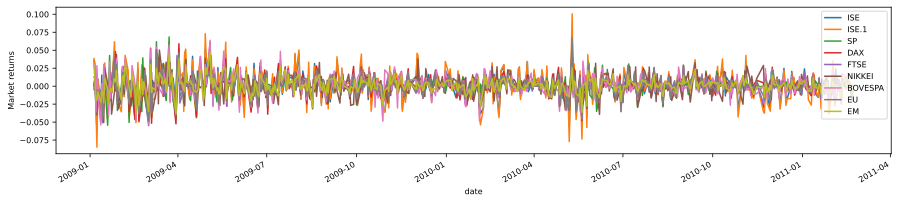

In [3]:
# show some data in line plots
data.plot(figsize=(15, 3), ylabel="Market returns")
plt.show()

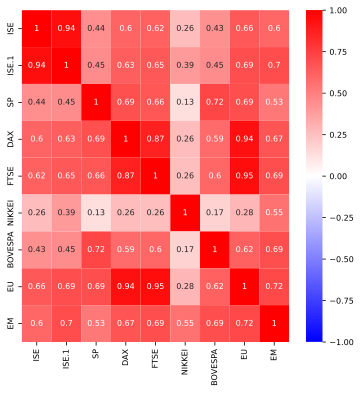

In [4]:
plt.figure(figsize=(6, 6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap="bwr")
plt.show()

(536, 9)


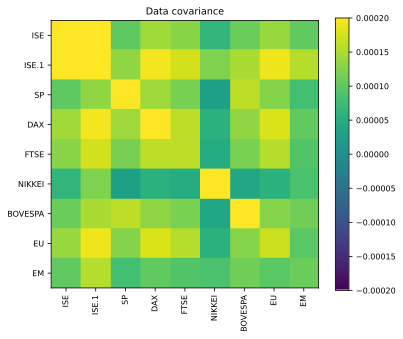

In [5]:
#### now for PCA!

# Step 1: covariance matrix
X = data.values  # extract data
print(X.shape)
X = X - np.mean(X, axis=0, keepdims=True)  # mean-center via broadcasting

# note: these data are observations-by-features, so we need X'X, not XX'
covmat = X.T @ X / (X.shape[0] - 1)

# visualize it
plt.figure(figsize=(6, 6))
plt.imshow(covmat, vmin=-0.0002, vmax=0.0002)
plt.colorbar(shrink=0.82)
plt.title("Data covariance")
plt.xticks(range(X.shape[1]), labels=data.columns, rotation=90)
plt.yticks(range(X.shape[1]), labels=data.columns)
plt.show()

(536, 2)


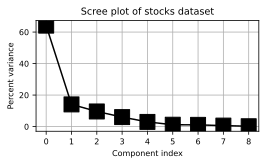

Variance of first two components:
[0.0013006  0.00028585]

First two eigenvalues:
[0.0013006  0.00028585]


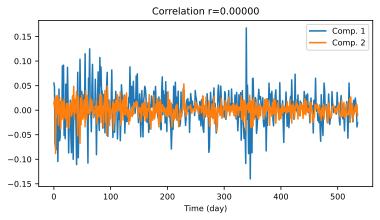

In [6]:
# Step 2: eigendecomposition
evals, evecs = np.linalg.eig(covmat)

# Step 3: sort results
sidx = np.argsort(evals)[::-1]
evals = evals[sidx]
evecs = evecs[:, sidx]


# Step 4: component scores
components = data.values @ evecs[:, 0:2]
print(components.shape)

# Step 5: eigenvalues to %var
factorScores = 100 * evals / np.sum(evals)

# show scree plot
plt.figure(figsize=(4, 2))
plt.plot(factorScores, "ks-", markersize=15)
plt.xlabel("Component index")
plt.ylabel("Percent variance")
plt.title("Scree plot of stocks dataset")
plt.grid()
plt.show()

# Show that variance of the components equals the eigenvalue
print("Variance of first two components:")
print(
    np.var(components, axis=0, ddof=1)
)  # note the ddof=1! The default produces the biased variance.

print(f"\nFirst two eigenvalues:")
print(evals[:2])

plt.figure(figsize=(6, 3))
plt.plot(components)
plt.xlabel("Time (day)")
plt.legend(["Comp. 1", "Comp. 2"])
plt.title(f"Correlation r={np.corrcoef(components.T)[0,1]:.5f}")
plt.show()

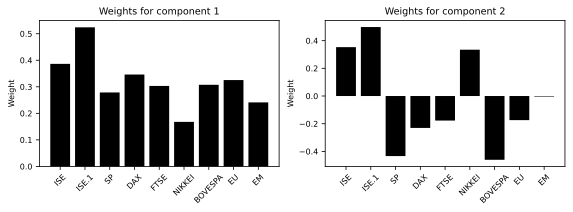

In [7]:
_, axs = plt.subplots(1, 2, figsize=(8, 3))

for i in range(2):
    axs[i].bar(range(X.shape[1]), evecs[:, i], color="black")
    axs[i].set_xticks(range(X.shape[1]))
    axs[i].set_xticklabels(data.columns, rotation=45)
    axs[i].set_ylabel("Weight")
    axs[i].set_title(f"Weights for component {i+1}")

plt.tight_layout()
plt.show()

###### ============================

(536, 9)
(536, 2)


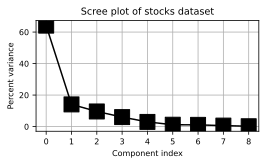

Variance of first two components:
[0.0013006  0.00028585]

First two singular values:
[0.0013006  0.00028585]


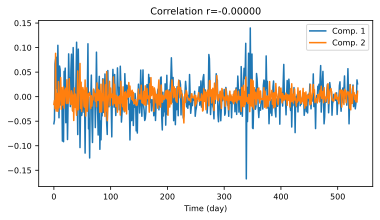

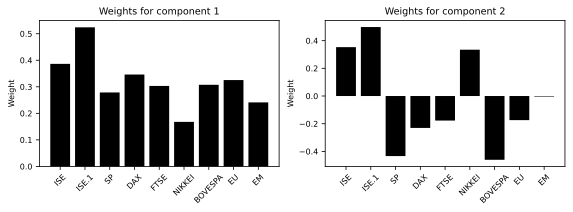

In [8]:
# Exer 2 - Part 1 SVD of covmat
X = data.values  # extract data
print(X.shape)
X = X - np.mean(X, axis=0, keepdims=True)  # mean-center via broadcasting
covmat = X.T @ X / [X.shape[0] - 1]

U, s, Vt = np.linalg.svd(covmat)

# Step 3: already sorted by svd function
# Step 4: component scores
components = data.values @ U[:, 0:2]
print(components.shape)

# Step 5: eigenvalues to %var
factorScores = 100 * s / np.sum(s)

# show scree plot
plt.figure(figsize=(4, 2))
plt.plot(factorScores, "ks-", markersize=15)
plt.xlabel("Component index")
plt.ylabel("Percent variance")
plt.title("Scree plot of stocks dataset")
plt.grid()
plt.show()

# Show that variance of the components equals the eigenvalue
print("Variance of first two components:")
print(
    np.var(components, axis=0, ddof=1)
)  # note the ddof=1! The default produces the biased variance.

print(f"\nFirst two singular values:")
print(evals[:2])

plt.figure(figsize=(6, 3))
plt.plot(components)
plt.xlabel("Time (day)")
plt.legend(["Comp. 1", "Comp. 2"])
plt.title(f"Correlation r={np.corrcoef(components.T)[0,1]:.5f}")
plt.show()


_, axs = plt.subplots(1, 2, figsize=(8, 3))

for i in range(2):
    axs[i].bar(range(X.shape[1]), -U[:, i], color="black")
    axs[i].set_xticks(range(X.shape[1]))
    axs[i].set_xticklabels(data.columns, rotation=45)
    axs[i].set_ylabel("Weight")
    axs[i].set_title(f"Weights for component {i+1}")

plt.tight_layout()
plt.show()

In [9]:
U, s, Vt = np.linalg.svd(X)  # SVD


# eigen/singular values
print("First 4 eigenvalues:")
print(evals[:4])

print(f"\nFirst 4 singular values:")
print(s[:4] ** 2 / (X.shape[0] - 1))


# eigen/singular vectors
print("\n\n\nFirst eigenvector:")
print(evecs[:, 0])

print("\nFirst right singular vector:")
print(Vt[0, :])

First 4 eigenvalues:
[0.0013006  0.00028585 0.00019503 0.00012253]

First 4 singular values:
[0.0013006  0.00028585 0.00019503 0.00012253]



First eigenvector:
[0.3864847  0.52390953 0.27860507 0.34621538 0.30322542 0.16781756
 0.30741897 0.32544121 0.24111348]

First right singular vector:
[-0.3864847  -0.52390953 -0.27860507 -0.34621538 -0.30322542 -0.16781756
 -0.30741897 -0.32544121 -0.24111348]


In [10]:
# Exer 3 - Using sklearn function to calculate PCA

pca = PCA()
X_t = pca.fit_transform(data)

# compare percent-normalized eigenvalues
print("Eigenvalues:")
print(evals[:4])

print(f"\nExplained variance from sklearn:")
print(pca.explained_variance_[:4])

# eigenvector and sklearn component
print("\n\n\nFirst eigenvector:")
print(evecs[:, 0])

print("\nFirst sklearn component vector:")
print(pca.components_[0, :])

Eigenvalues:
[0.0013006  0.00028585 0.00019503 0.00012253]

Explained variance from sklearn:
[0.0013006  0.00028585 0.00019503 0.00012253]



First eigenvector:
[0.3864847  0.52390953 0.27860507 0.34621538 0.30322542 0.16781756
 0.30741897 0.32544121 0.24111348]

First sklearn component vector:
[0.3864847  0.52390953 0.27860507 0.34621538 0.30322542 0.16781756
 0.30741897 0.32544121 0.24111348]


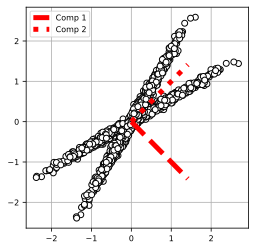

In [11]:
# Exer 4
A = np.random.randn(1000, 2)
A[:, 1] *= 0.05

th = -np.pi / 6
R1 = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
th = -np.pi / 3
R2 = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])

X = np.vstack((A @ R1, A @ R2))
X_mean = np.mean(X, axis=0, keepdims=True)
U, s, Vt = np.linalg.svd(X - X_mean)

s = s**2 / (X.shape[0] - 1)
Vt *= 2

plt.figure(figsize=(4, 4))
plt.plot(X[:, 0], X[:, 1], "ko", markerfacecolor="w")

plt.plot([0, Vt[0, 0]], [0, Vt[1, 0]], "r--", linewidth=5, label="Comp 1")
plt.plot([0, Vt[0, 1]], [0, Vt[1, 1]], "r:", linewidth=5, label="Comp 2")

plt.legend()
plt.grid()
plt.show()

###### ============================
### Linear Discriminant Analysis (LDA)

It's a multivariate classification technique.

Goal is to find a direction in the data space that maximally separates categoris of data. LDA will find basis vectors in the data space that maximally separate the the categoris of data.

LDA is similar to PCA. But in PCA we want to maximize the variance in a data set, but in LDA we want to maximize the ratio of the variance between TWO datasets.

#### The Math

It's based on the generlized eigendecompostion.

So if we have two data sets $X_B$ and $X_W$, we want to find weights w that maximizes the following ratio:

$$\lambda=\frac{||X_Bw||^2}{||X_Ww||^2}$$

Same is PCA if we consider all sets of $w$:

$$\Lambda=(W^TC_WW)^{-1}W^TC_BW \implies C_WW\Lambda=C_BW$$

- $C_W$ is the within-class covariance, and is created by computing the covariance of each class and then average those covariance matrices.
- $C_B$ is the between-class covariance, and is created by taking the mean of each data feature within each class, and then concatenating those feature mean-vectors for all classes. and tehn we calculate the covariance of tthe matrix.

So it's the same as the generlized eigen decomposition. The eigenvectors are the weights and the generaized eigenvalues are the variance ratios of each component.

- The eogenvectors obtained here are not orthogonal
- LDA is a linear solution and does not work if the dats is not linearly separables.



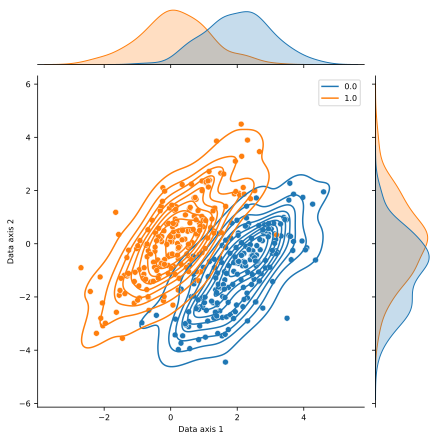

In [12]:
# Exer 5

# create the data
N = 200

class1 = np.random.randn(N, 2)
class1[:, 1] += class1[:, 0]
class1 += np.array([2, -1])

class2 = np.random.randn(N, 2)
class2[:, 1] += class2[:, 0]

# for later, it will be convenient to have the data in one matrix
alldata = np.vstack((class1, class2))
labels = np.append(np.zeros(N), np.ones(N))

# show data in their original data space
ax = sns.jointplot(x=alldata[:, 0], y=alldata[:, 1], hue=labels)
ax.ax_joint.set_xlabel("Data axis 1")
ax.ax_joint.set_ylabel("Data axis 2")
ax.plot_joint(sns.kdeplot)
plt.show()

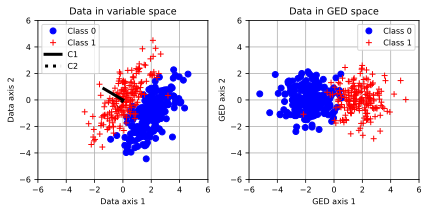

In [13]:
# Exer 6
# between-class covariance
cmc1 = np.mean(class1, axis=0)
cmc2 = np.mean(class2, axis=0)
covB = np.cov(np.vstack((cmc1, cmc2)).T, ddof=1)

# within-class covariances
cov1 = np.cov(class1.T, ddof=1)
cov2 = np.cov(class2.T, ddof=1)
covW = (cov1 + cov2) / 2

# LDA via GED
from scipy.linalg import eigh

evals, evecs = eigh(covB, covW)

# sort the solution
sidx = np.argsort(evals)[::-1]
evals = evals[sidx]
evecs = evecs[:, sidx]

# project the mean-centered data onto the GED axes
projA = (alldata - np.mean(alldata, axis=0)) @ evecs  # A=all


# show the data
_, axs = plt.subplots(1, 2, figsize=(6, 3))
marker = ["bo", "r+"]
for i in range(2):
    axs[0].plot(
        alldata[labels == i, 0], alldata[labels == i, 1], marker[i], label=f"Class {i}"
    )

axs[0].plot([0, evecs[0, 0]], [0, evecs[1, 0]], "k-", linewidth=3, label="C1")
axs[0].plot([0, evecs[0, 1]], [0, evecs[1, 1]], "k:", linewidth=3, label="C2")
axs[0].set_xlabel("Data axis 1")
axs[0].set_ylabel("Data axis 2")
axs[0].set_title("Data in variable space")


# and again in the GED space
for i in range(2):
    axs[1].plot(
        projA[labels == i, 0], projA[labels == i, 1], marker[i], label=f"Class {i}"
    )
axs[1].set_xlabel("GED axis 1")
axs[1].set_ylabel("GED axis 2")
axs[1].set_title("Data in GED space")


# common settings
for i in range(2):
    axs[i].axis([-6, 6, -6, 6])
    axs[i].grid()
    axs[i].legend()

plt.tight_layout()
plt.show()

Prediction accuracy: 97.0%


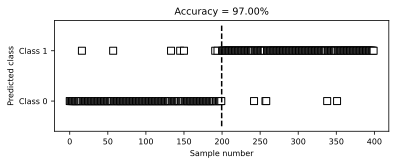

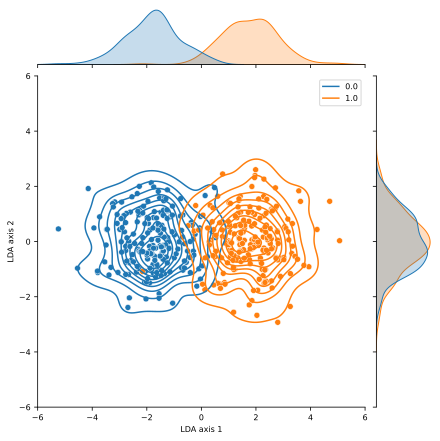

In [14]:
# prediction (converted to ints)
predictedLabel = (projA[:, 0] > 0) + 0

print(f"Prediction accuracy: {100*np.mean( predictedLabel==labels )}%")

# show the results
plt.figure(figsize=(6, 2))
plt.plot(predictedLabel, "ks", markersize=7, markerfacecolor="w", linewidth=2)
plt.plot([N - 0.5, N - 0.5], [-0.5, 1.5], "k--")
plt.xlabel("Sample number")
plt.ylabel("Predicted class")
plt.yticks([0, 1], labels=["Class 0", "Class 1"])
plt.title(f"Accuracy = {100*np.mean(predictedLabel==labels):.2f}%")
plt.show()


# redraw the jointplot in the GED space (used in Figure 2)
ax = sns.jointplot(x=projA[:, 0], y=projA[:, 1], hue=labels, xlim=[-6, 6], ylim=[-6, 6])
ax.ax_joint.set_xlabel("LDA axis 1")
ax.ax_joint.set_ylabel("LDA axis 2")
ax.plot_joint(sns.kdeplot)
plt.show()

In [15]:
# Exer 7

# not the identity matrix!
print("V'V:")
print(np.round(evecs.T @ evecs, 3))


# yes the identity matrix!
print(f"\nV'RV:")
print(np.round(evecs.T @ covW @ evecs, 3))

V'V:
[[ 2.529 -0.011]
 [-0.011  0.379]]

V'RV:
[[1. 0.]
 [0. 1.]]


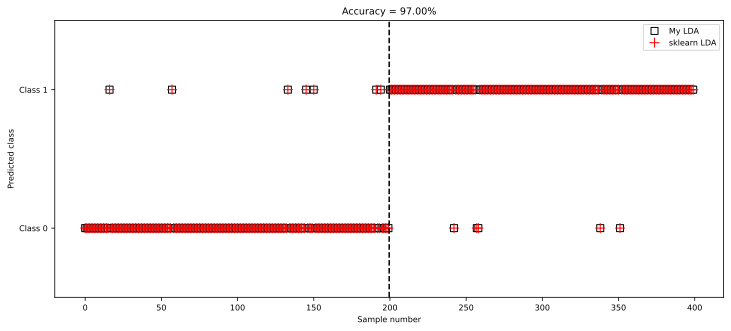

In [16]:
# Exer 8

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

ldamodel = LDA(solver="eigen")
ldamodel.fit(alldata, labels)


# show the results
plt.figure(figsize=(12, 5))
plt.plot(
    predictedLabel, "ks", markersize=7, markerfacecolor="w", linewidth=2, label="My LDA"
)
plt.plot(
    ldamodel.predict(alldata),
    "r+",
    markersize=10,
    markerfacecolor="w",
    linewidth=2,
    label="sklearn LDA",
)
plt.plot([N - 0.5, N - 0.5], [-0.5, 1.5], "k--")
plt.xlabel("Sample number")
plt.ylabel("Predicted class")
plt.yticks([0, 1], labels=["Class 0", "Class 1"])
plt.ylim([-0.5, 1.5])
plt.legend()
plt.title(f"Accuracy = {100*np.mean(ldamodel.predict(alldata)==labels):.2f}%")
plt.show()

###### ============================
### Low-Rank Approximation via SVD

Idea is to take the SVD of a data matrix and then reconstruct the data using some of subset of SVD components. It is also possible to just use a rectangular version of S that only contains the singular values we want to use.

### Denoising

The low-rank approximation can be used to omit noise in data by rempoving some of the singular values which contribute to the noise in the data set. These singular values are not necesserily small, as opposed to data compression.


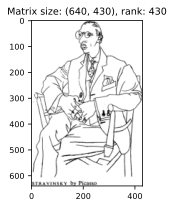

In [17]:
# Exer 10

from skimage import io, color

url = "https://upload.wikimedia.org/wikipedia/ka/1/1c/Stravinsky_picasso.png"

# import picture and downsample to 2D
strav = io.imread(url)
strav = color.rgb2gray(strav)

plt.figure(figsize=(3, 3))
plt.imshow(strav, cmap="gray")
plt.title(f"Matrix size: {strav.shape}, rank: {np.linalg.matrix_rank(strav)}")
plt.show()

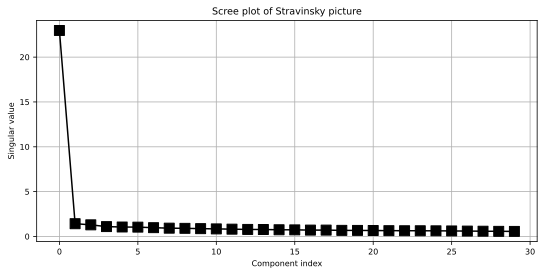

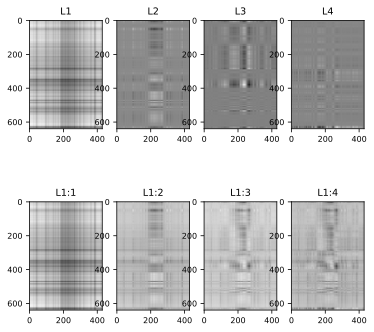

In [18]:
def reconstruct_image(image, NumLayers, scree):
    U, s, Vt = np.linalg.svd(image)

    S = np.zeros(image.shape)
    np.fill_diagonal(S, s)

    # show scree plot
    if scree == True:
        plt.figure(figsize=(9, 4))
        plt.plot(s[:30] * 100 / np.sum(s), "ks-", markersize=10)
        plt.xlabel("Component index")
        plt.ylabel("Singular value")
        plt.title("Scree plot of Stravinsky picture")
        plt.grid()
        plt.show()

    layers = np.zeros((NumLayers, image.shape[0], image.shape[1]))
    recons = np.zeros((NumLayers, image.shape[0], image.shape[1]))

    for i in range(NumLayers):
        layers[i, :, :] = s[i] * np.outer(U[:, i], Vt[i, :])
        recons[i, :, :] = np.sum(layers[: i + 1, :, :], axis=0)

    return layers, recons


def create_output_image(layers, recons):
    NumLayers = layers.shape[0]
    fig, axs = plt.subplots(2, NumLayers, figsize=(6, 6))
    for i in range(NumLayers):
        axs[0, i].imshow(layers[i, :, :], cmap="gray")
        axs[0, i].set_title(f"L{i+1}")
        axs[1, i].imshow(recons[i, :, :], cmap="gray")
        axs[1, i].set_title(f"L1:{i+1}")
    plt.show()

    return


layers, recons = reconstruct_image(strav, 4, True)

create_output_image(layers, recons)

      Original is 2.10 mb
Reconstruction is 2.10 mb
Recon vectors are 1.53 mb (using k=100 comps.)

Compression of 72.68%


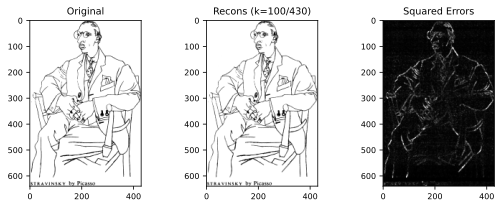

In [19]:
# Exer 11
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(strav, cmap="gray", vmin=0.1, vmax=0.9)
axs[0].set_title("Original")

NumLayers = 100
layers, recons = reconstruct_image(strav, NumLayers, False)

axs[1].imshow(recons[-1, :, :], cmap="gray", vmin=0.1, vmax=0.9)
axs[1].set_title(f"Recons (k={NumLayers}/{430})")

error = (strav - recons[-1, :, :]) ** 2
axs[2].imshow(error, cmap="gray", vmin=0, vmax=0.1)
axs[2].set_title(f"Squared Errors")

# compute sizes of the images
stravSize = strav.nbytes / 1024**2
stravRSize = recons[-1, :, :].nbytes / 1024**2

k = NumLayers
# and of the vectors/values
uSize = U[:, :k].nbytes / 1024**2
sSize = s[:k].nbytes / 1024**2
vSize = Vt[:k, :].nbytes / 1024**2


# print image sizes
print(f"      Original is {stravSize:.2f} mb")
print(f"Reconstruction is {stravRSize:.2f} mb")
print(f"Recon vectors are {uSize+sSize+vSize:.2f} mb (using k={k} comps.)")

print(f"\nCompression of {100*(uSize+sSize+vSize)/stravSize:.2f}%")

Text(0, 0.5, 'Error')

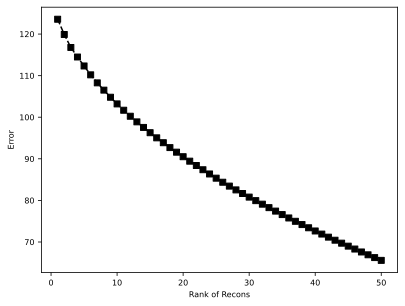

In [20]:
k_max = 50
norm_list = np.zeros(k_max)

for i in range(1, k_max + 1):
    _, recons = reconstruct_image(strav, i, False)
    norm_list[i - 1] = np.linalg.norm(strav - recons[-1, :, :], "fro")


plt.plot(figsize=(6, 3))

k = np.linspace(1, k_max, k_max)
plt.plot(k, norm_list, "ks--")
plt.xlabel("Rank of Recons")
plt.ylabel("Error")

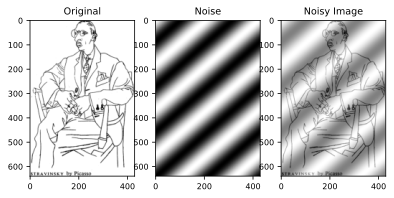

In [21]:
# exer 13

f = 0.02
theta = np.pi / 3

[x, y] = np.meshgrid(
    np.linspace(-100, 100, strav.shape[1]), np.linspace(-100, 100, strav.shape[0])
)

Z = np.sin(2 * np.pi * f * (x * np.cos(theta) + y * np.sin(theta)))

Z = (Z - np.min(Z)) / (np.max(Z) - np.min(Z))

strav_noisy = strav + Z
strav_noisy = (strav_noisy - np.min(strav_noisy)) / (
    np.max(strav_noisy) - np.min(strav_noisy)
)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(strav, cmap="gray")
axs[0].set_title("Original")
axs[1].imshow(Z, cmap="gray")
axs[1].set_title("Noise")
axs[2].imshow(strav_noisy, cmap="gray")
axs[2].set_title("Noisy Image")
plt.show()

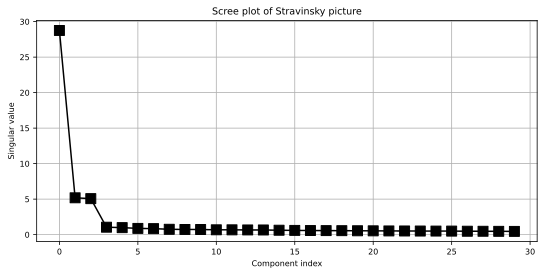

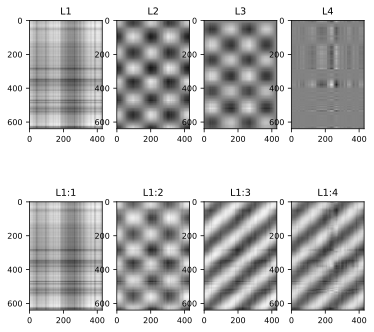

In [22]:
layers, recons = reconstruct_image(strav_noisy, 4, True)
create_output_image(layers, recons)

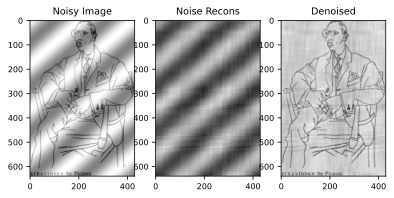

In [23]:
# Exer 14

image = strav_noisy.copy()

U, s, Vt = np.linalg.svd(image)

S = np.zeros(image.shape)
np.fill_diagonal(S, s)

# reconstruction of the noise Based on 1 and 2 components
noiseComps = np.array([1, 2])
stravRecNoise = U[:, noiseComps] @ S[noiseComps, :][:, noiseComps] @ Vt[noiseComps, :]


# reconstruction of the image with noise projected out
noNoiseCompsU = np.full(U.shape[0], True)
noNoiseCompsU[noiseComps] = False

noNoiseCompsV = np.full(Vt.shape[0], True)
noNoiseCompsV[noiseComps] = False

# here's the image without the noise components
strav_denoised = (
    U[:, noNoiseCompsU] @ S[noNoiseCompsU, :][:, noNoiseCompsV] @ Vt[noNoiseCompsV, :]
)


fig, axs = plt.subplots(1, 3)
axs[0].imshow(strav_noisy, cmap="gray")
axs[0].set_title("Noisy Image")

axs[1].imshow(stravRecNoise, cmap="gray", vmin=-0.5, vmax=0.5)
axs[1].set_title("Noise Recons")
axs[2].imshow(strav_denoised, cmap="gray", vmin=0.1, vmax=0.9)
axs[2].set_title("Denoised")
plt.show()